### Problem Statement
Mining companies face problems regarding the impurities present in Ore. More the impurities poorer the ore. 
In this problem we have to classify the **Grade** (quality) of Iron ore at the end process based on Silica present. <br/> 
Grade 1- Supreme Quality<br/>
Grade 2- Good Quality<br/>
Grade 3- Average Quality<br/>
Grade 4- Poor Quality

### Installing required packages

In [58]:
!pip install lime
!pip install eli5
!pip install shap

In [ ]:
!pip install pandas_profiling
!pip install scikit-learn

## Import the required Libraries

In [1]:
import pandas as pd
import pandas_profiling
import dask.dataframe as dd
pd.options.display.max_columns=False
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
# import lime
# import eli5
# import shap
%matplotlib inline

**Import the data set**

In [ ]:
from google.colab import files
files.upload()

**Read the data with dask**

In [9]:
%time
dask_train = dd.read_csv('Iron_mining.xls',decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()     # Reading data using dask

Wall time: 0 ns


**Read the data using pandas** 

In [2]:
%time
df=pd.read_csv('Iron_mining.xls',decimal=",",parse_dates=["date"],infer_datetime_format=True).drop_duplicates()

Wall time: 0 ns


In [3]:
df.shape  #26 columns

(5000, 26)

In [12]:
df.head()

Unnamed: 0                date % Iron Feed  ...  % Iron Concentrate % Silica Concentrate grade
0      677134 2017-08-27 00:00:00       63.64  ...               65.99                 1.04     2
1      529548 2017-07-23 20:00:00       57.44  ...               65.95                  1.6     2
2       88250 2017-04-12 17:00:00       56.77  ...               64.35                 2.64     3
3      714298 2017-09-04 15:00:00       54.14  ...               64.25                  2.3     3
4      710528 2017-09-03 18:00:00       55.99  ...               64.69                 3.02     4

[5 rows x 26 columns]

**Exploratory Data Analysis**

In [4]:
del df['Unnamed: 0']                                                                     # Lets drop the unnamed column

In [5]:
df.info()                                                                                # Check the info of the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
date                            5000 non-null datetime64[ns]
% Iron Feed                     5000 non-null object
% Silica Feed                   5000 non-null object
Starch Flow                     5000 non-null object
Amina Flow                      5000 non-null object
Ore Pulp Flow                   5000 non-null object
Ore Pulp pH                     5000 non-null object
Ore Pulp Density                5000 non-null object
Flotation Column 01 Air Flow    5000 non-null object
Flotation Column 02 Air Flow    5000 non-null object
Flotation Column 03 Air Flow    5000 non-null object
Flotation Column 04 Air Flow    5000 non-null object
Flotation Column 05 Air Flow    5000 non-null object
Flotation Column 06 Air Flow    5000 non-null object
Flotation Column 07 Air Flow    5000 non-null object
Flotation Column 01 Level       5000 non-null object
Flotation Column 02 Level       5000 

**Feature Extraction**<br/>
Extract Hour, Month and Day columns from Date column

In [7]:
df['Hour']=df['date'].dt.hour
df['Month']=df['date'].dt.month

In [8]:
df['day']=df['date'].dt.dayofweek

In [9]:
df['day'].value_counts()                                                        # Day counts across the data set

4    735
0    732
2    718
6    716
5    710
3    708
1    681
Name: day, dtype: int64

That infers data of sunday, monday, ..sat data are equally destributed

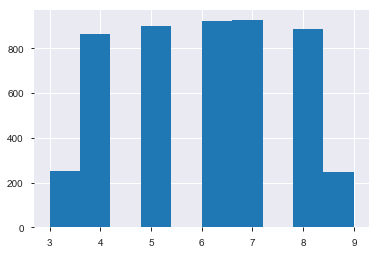

In [13]:
df['Month'].hist()

In [ ]:
There id no entry 10,11,12 as this is winter season thus no mining happens.

In [12]:
del df['date']                                                                  # We can delete date column as it's not required any longer

**Let's check shape, missing values and data types of the variables**

In [21]:
print('Shape of the data \n',df.shape)
print('###############--------------')
print('Find Missing values if present\n',df.isnull().sum())
print('###############--------------')
print('Datatype\n',df.dtypes)

Shape of the data 
 (5000, 27)
###############--------------
Find Missing values if present
 % Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
Flotation Column 04 Air Flow    0
Flotation Column 05 Air Flow    0
Flotation Column 06 Air Flow    0
Flotation Column 07 Air Flow    0
Flotation Column 01 Level       0
Flotation Column 02 Level       0
Flotation Column 03 Level       0
Flotation Column 04 Level       0
Flotation Column 05 Level       0
Flotation Column 06 Level       0
Flotation Column 07 Level       0
% Iron Concentrate              0
% Silica Concentrate            0
grade                           0
Hour                            0
Month                           0
day                    

**Converting columns having object data type into numeric ones**

In [14]:
new_df=df.iloc[:,:-5].astype(float)

In [15]:
new_df1=pd.concat([new_df,df.iloc[:,-4:]],axis=1)                             # Merging all the numeric columns

In [27]:
round(new_df1.head(),2)

% Iron Feed  % Silica Feed  Starch Flow  Amina Flow  Ore Pulp Flow ...   % Iron Concentrate  grade  Hour  Month  day
0        63.64           3.77      2409.63      473.91         379.66 ...                65.99      2     0      8    6
1        57.44          14.09      3495.86      514.53         396.18 ...                65.95      2    20      7    6
2        56.77          11.98      2074.22      548.71         400.78 ...                64.35      3    17      4    2
3        54.14          14.69      1122.45      477.28         382.71 ...                64.25      3    15      9    0
4        55.99          15.13      3266.57      525.78         378.74 ...                64.69      4    18      9    6

[5 rows x 26 columns]

**Let's take a look at the Descriptive Statistics of the data set**

In [17]:
new_df1.describe()

% Iron Feed  % Silica Feed  Starch Flow     ...              Hour        Month          day
count  5000.000000    5000.000000  5000.000000     ...       5000.000000  5000.000000  5000.000000
mean     56.287182      14.660398  2885.549793     ...         11.618000     6.011400     3.005400
std       5.123272       6.736497  1226.564669     ...          6.903188     1.632484     2.002641
min      42.740000       1.310000     0.926983     ...          0.000000     3.000000     0.000000
25%      52.670000       8.990000  2077.735156     ...          6.000000     5.000000     1.000000
50%      55.990000      14.090000  3022.215000     ...         12.000000     6.000000     3.000000
75%      59.660000      19.580000  3748.682500     ...         18.000000     7.000000     5.000000
max      65.780000      33.400000  6294.080000     ...         23.000000     9.000000     6.000000

[8 rows x 26 columns]

Hypothesis : As there is marginal difference between mean and median(50%) we can say that there are no outliers in dataset.

**Pandas profiling**

In [29]:
report=pandas_profiling.ProfileReport(new_df1)
report

In [ ]:
del new_df1['Flotation Column 03 Air Flow'] # removing this column as it has correlation with another column

**Correlation plot**

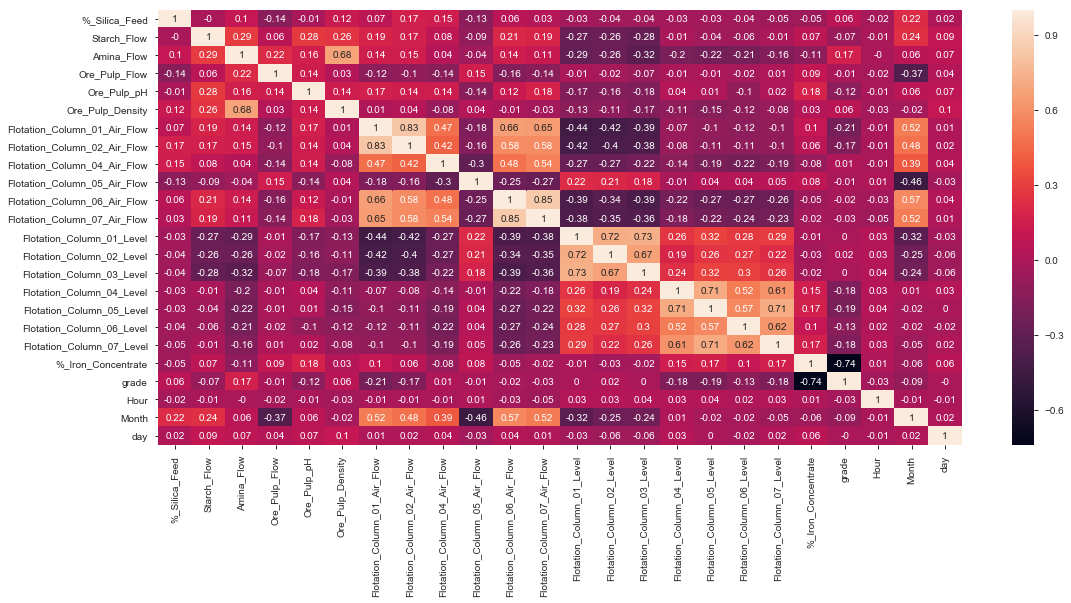

In [36]:

plt.figure(figsize=[18,8])
sns.heatmap(round(new_df1.iloc[:,1:].corr(),2),annot=True)
plt.show()

**Boxplot:**<br/> Check outliers across the variables

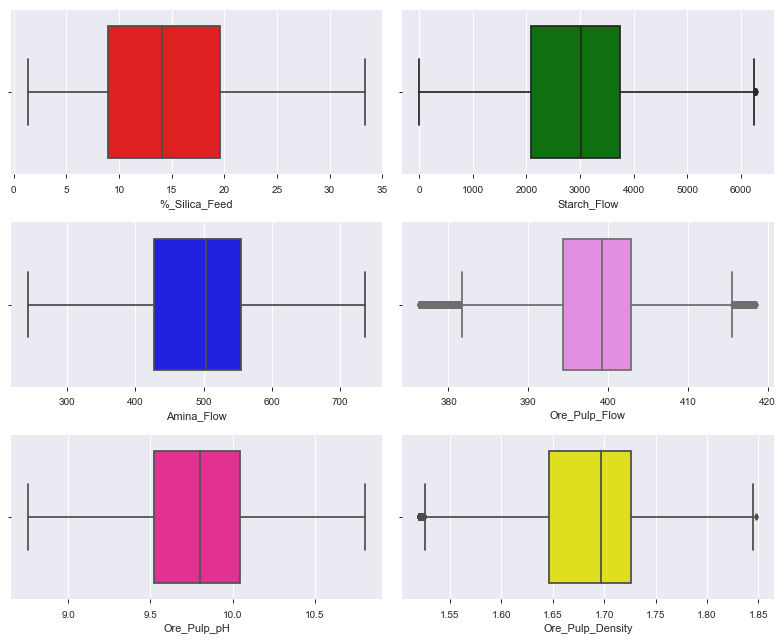

In [37]:
# Checking the box plot of the first 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.boxplot(new_df1.iloc[:,1],color='r')
plt.subplot(322)
sns.boxplot(new_df1.iloc[:,2],color='g')
plt.subplot(323)
sns.boxplot(new_df1.iloc[:,3],color='b')
plt.subplot(324)
sns.boxplot(new_df1.iloc[:,4],color='violet')
plt.subplot(325)
sns.boxplot(new_df1.iloc[:,5],color='deeppink')
plt.subplot(326)
sns.boxplot(new_df1.iloc[:,6],color='yellow')
plt.tight_layout()
plt.show()

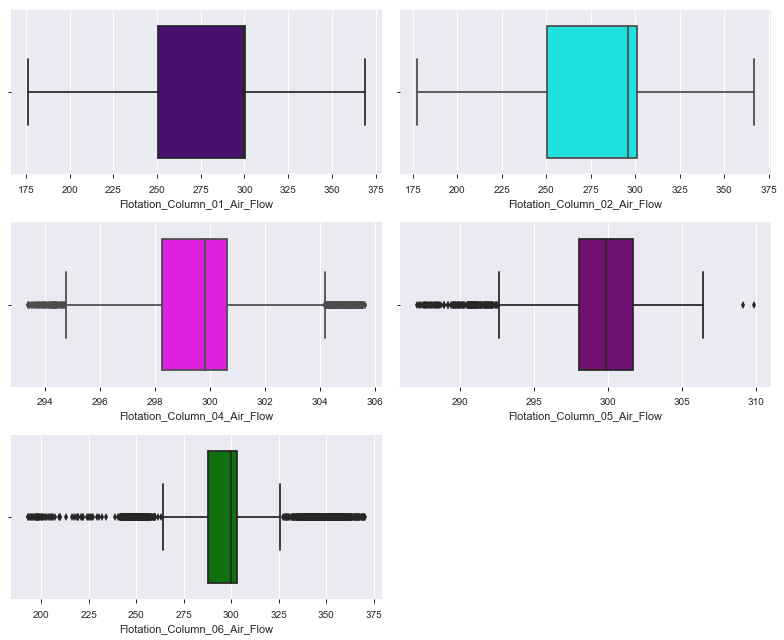

In [38]:
# Checking the box plot of the next 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.boxplot(new_df1.iloc[:,7],color='indigo')
plt.subplot(322)
sns.boxplot(new_df1.iloc[:,8],color='cyan')
plt.subplot(323)
sns.boxplot(new_df1.iloc[:,9],color='magenta')
plt.subplot(324)
sns.boxplot(new_df1.iloc[:,10],color='purple')
plt.subplot(325)
sns.boxplot(new_df1.iloc[:,11],color='green')
plt.tight_layout()
plt.show()

**Observation** : From the quartile division, it is pretty evident that data points across the vairiables are consistent, i.e. no influence of outliers, though standard deviation in most of the variables is large. 

C:\Users\Harsh\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


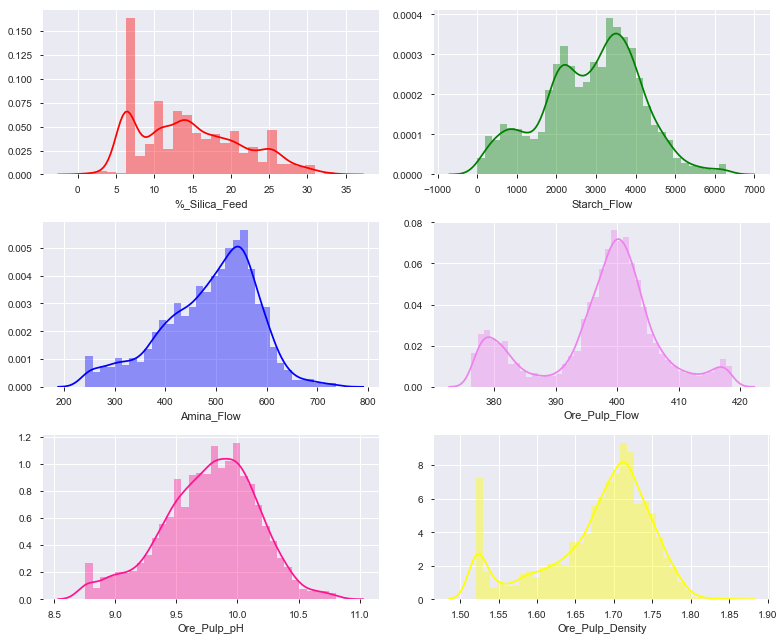

In [39]:
# Checking the histigram of the first 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.distplot(new_df1.iloc[:,1],color='r')
plt.subplot(322)
sns.distplot(new_df1.iloc[:,2],color='g')
plt.subplot(323)
sns.distplot(new_df1.iloc[:,3],color='b')
plt.subplot(324)
sns.distplot(new_df1.iloc[:,4],color='violet')
plt.subplot(325)
sns.distplot(new_df1.iloc[:,5],color='deeppink')
plt.subplot(326)
sns.distplot(new_df1.iloc[:,6],color='yellow')
plt.tight_layout()
plt.show()

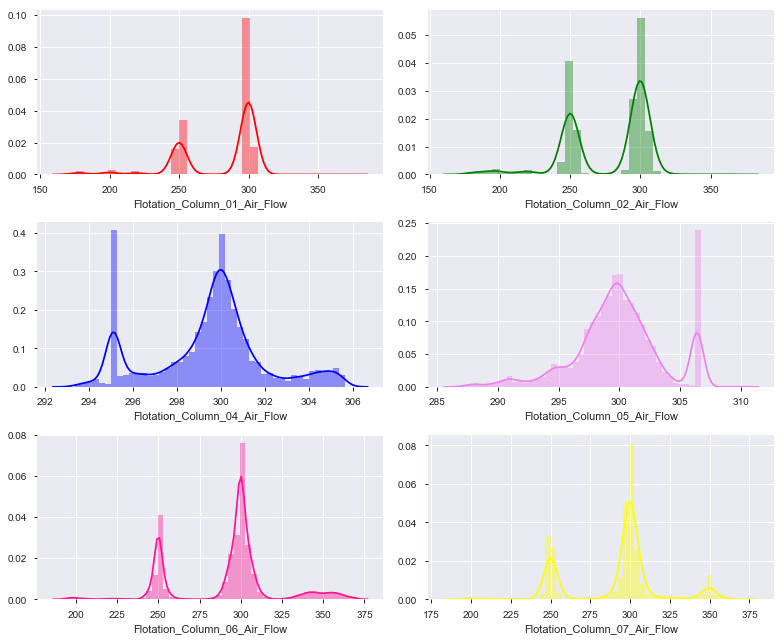

In [40]:
# Checking the histogram of the next 6 columns

plt.figure(figsize=[11,9])
plt.subplot(321)
sns.distplot(new_df1.iloc[:,7],color='r')
plt.subplot(322)
sns.distplot(new_df1.iloc[:,8],color='g')
plt.subplot(323)
sns.distplot(new_df1.iloc[:,9],color='b')
plt.subplot(324)
sns.distplot(new_df1.iloc[:,10],color='violet')
plt.subplot(325)
sns.distplot(new_df1.iloc[:,11],color='deeppink')
plt.subplot(326)
sns.distplot(new_df1.iloc[:,12],color='yellow')
plt.tight_layout()
plt.show()

we can see that its a bimodal distribution. so if we use test_train split, it may happen that test data will have one peak 
and training data may have another peak. so cross fold is good model to choose here.

In [41]:
new_df1['grade'].value_counts()                                                 # Frequency of each of 4 categories

2    2437
3    1285
4    1258
1      20
Name: grade, dtype: int64

Here class 2 is more prominent and 3 and 4 are equally distributed and 1 is rare. its imbalanced dataset.

**Creating the features and the labels**

In [24]:
y=new_df1.loc[:,'grade']
new_df1.drop(['grade'],axis=1,inplace=True)
x=new_df1

**Dummy encode the categorical columns**

In [25]:
cols=['Hour','Month','day']                                                      # These are the categorical columns
cat_cols=x[cols]
cat_cols=cat_cols.astype(str)

In [26]:
dummies=pd.get_dummies(cat_cols,drop_first=True)

In [27]:
dummies.head()

Hour_1  Hour_10  Hour_11  Hour_12  Hour_13  Hour_14  ...    day_1  day_2  day_3  day_4  day_5  day_6
0       0        0        0        0        0        0  ...        0      0      0      0      0      1
1       0        0        0        0        0        0  ...        0      0      0      0      0      1
2       0        0        0        0        0        0  ...        0      1      0      0      0      0
3       0        0        0        0        0        0  ...        0      0      0      0      0      0
4       0        0        0        0        0        0  ...        0      0      0      0      0      1

[5 rows x 35 columns]

In [28]:
input_features=pd.concat([x,dummies],axis=1)                                     # Concat the dummy variables with x(Input features)

In [29]:
input_features.shape                                                             # Now we have 5000 rows and 60 columns

(5000, 59)

**Train-Test split for training and validation**

In [30]:
x_train,x_test,y_train,y_test=train_test_split(input_features,y,test_size=0.2,random_state=1234)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4000, 59)
(1000, 59)
(4000,)
(1000,)


##Training models

**Logistic Regression**

In [31]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=101)

In [32]:
lr_model=lr.fit(x_train,y_train)

C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [33]:
lr_pred=lr_model.predict(x_test)

0.713
********************************************
Confusion matrix


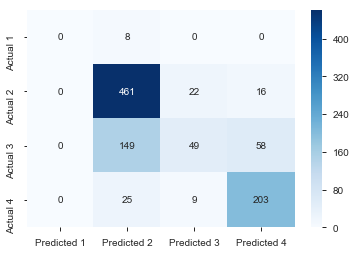

**********************************************
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.72      0.92      0.81       499
           3       0.61      0.19      0.29       256
           4       0.73      0.86      0.79       237

   micro avg       0.71      0.71      0.71      1000
   macro avg       0.52      0.49      0.47      1000
weighted avg       0.69      0.71      0.66      1000



C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [52]:
print(metrics.accuracy_score(y_test,lr_pred))
print('********************************************')
print('Confusion matrix')
lr_cfm=metrics.confusion_matrix(y_test, lr_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(lr_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('**********************************************')
print(metrics.classification_report(y_test,lr_pred))

For class 1 total 8 data points and none get correct
for class 2 there are 461 + 22 +16 data points and 461 got correct because its the prominent one
For class 3 toal 149+49+58 and 49 are correct
for class 4 total 25+ 9 +203 and 203 are correct.

**Decision Tree classifier**

In [34]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'entropy',max_depth = 10, min_samples_leaf =3, random_state=101)

In [35]:
dt_model=dt.fit(x_train,y_train)
dt_pred=dt_model.predict(x_test)

0.75
***************************************
Confusion matrix


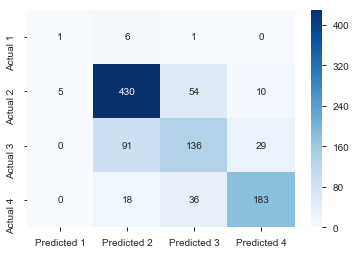

****************************************
              precision    recall  f1-score   support

           1       0.17      0.12      0.14         8
           2       0.79      0.86      0.82       499
           3       0.60      0.53      0.56       256
           4       0.82      0.77      0.80       237

   micro avg       0.75      0.75      0.75      1000
   macro avg       0.59      0.57      0.58      1000
weighted avg       0.74      0.75      0.75      1000



In [36]:
print(metrics.accuracy_score(y_test,dt_pred))
print('***************************************')
print('Confusion matrix')
dt_cfm=metrics.confusion_matrix(y_test, dt_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(dt_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('****************************************')
print(metrics.classification_report(y_test,dt_pred))

**RandomForest with Grid Search**

In [37]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(oob_score=True)

#### GridSearchCV

In [38]:
random_grid = {'n_estimators': range(5,20,3),
              'max_features' : ['auto', 'sqrt'],
              'max_depth' : [5,10,20,30],
              'min_samples_split':[2,5,10],
              'criterion':['entropy'],
              'min_samples_leaf':[1,2,4]}

rf = RandomForestClassifier()

rf_gs = GridSearchCV(rf, random_grid, cv = 5, n_jobs=-1, verbose=2)

rf_gs.fit(x_train, y_train)
y_pred = rf_gs.predict(x_test)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  3.0min finished


0.803
*******************************************
Confusion matrix


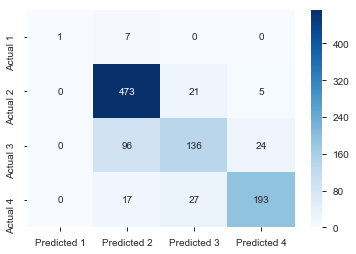

********************************************
              precision    recall  f1-score   support

           1       1.00      0.12      0.22         8
           2       0.80      0.95      0.87       499
           3       0.74      0.53      0.62       256
           4       0.87      0.81      0.84       237

   micro avg       0.80      0.80      0.80      1000
   macro avg       0.85      0.60      0.64      1000
weighted avg       0.80      0.80      0.79      1000



In [40]:
print(metrics.accuracy_score(y_test,y_pred))
print('*******************************************')
print('Confusion matrix')
rf_cfm=metrics.confusion_matrix(y_test, y_pred)

lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(rf_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)
plt.show()

print('********************************************')
print(metrics.classification_report(y_test,y_pred))

**XGBoost**<br/>

In [42]:
!pip install xgboost

In [43]:
from xgboost.sklearn import XGBClassifier

In [44]:
xgb_model = XGBClassifier(num_class = 4,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42) 

In [45]:
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, num_class=4, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=None, subsample=1, verbosity=1)

In [46]:
xgboost_pred=xgb_model.predict(x_test)

0.785
************
Confusion matrix


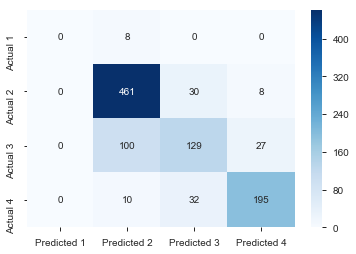

************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.80      0.92      0.86       499
           3       0.68      0.50      0.58       256
           4       0.85      0.82      0.84       237

   micro avg       0.79      0.79      0.79      1000
   macro avg       0.58      0.56      0.57      1000
weighted avg       0.77      0.79      0.77      1000



C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
print(metrics.accuracy_score(y_test,xgboost_pred))
print('************')
print('Confusion matrix')
xgboost_cm=metrics.confusion_matrix(y_test, xgboost_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(xgboost_cm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('************\n Classification report')
print(metrics.classification_report(y_test,xgboost_pred))

**XgBoost with Grid Search**

In [ ]:
xgb_gs_clf = XGBClassifier(num_class = 4,
                           objective="multi:softprob",
                           eval_metric="mlogloss",
                           seed=42)                         
                        
param_grid = {"max_depth": [10,15,20,30],
              "n_estimators": range(5,20,2) , 
              "gamma": [0.03,0.05], 
              "learning_rate": [0.01,0.05]}
#              "min_child_weight": [5,10], 
#              "colsample_bytree": [0.4,0.8], 
#              "subsample": [0.50,0.85]} 

grid_search = GridSearchCV(xgb_gs_clf, 
                           param_grid=param_grid,
                           cv = 5,
                           n_jobs=-1,
                           scoring='neg_log_loss',
                           verbose=2)
grid_search.fit(x_train,y_train)

In [ ]:
xgboost_y_pred=grid_search.predict(x_test)                                      # Validating the model by predicting the test data

In [ ]:
print(metrics.accuracy_score(y_test,xgboost_y_pred))
print('*************************************************')
print('Confusion matrix')
xgboost_cfm=metrics.confusion_matrix(y_test, xgboost_y_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(xgboost_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,xgboost_y_pred))

**LightGBM**

In [49]:
!pip install lightgbm

In [50]:
import lightgbm as lgb

d_train= lgb.Dataset(x_train, label = y_train)                                        # LightGBM dataset format

In [51]:
params = {}
params['learning_rate'] = 0.01                                             # Learning rate
params['boosting_type'] = 'gbdt'                                           # gbdt = gradient boosted decision tree
params['objective'] = 'multiclass'                                         # Multi class classification
params['metric'] = 'multi_logloss'
params['num_classes'] = 5 
#params['sub_feature'] = 0.5
#params['min_data'] = 50
#params['max_depth'] = 10


clf = lgb.train(params, d_train)                                                      # Training the model for 10 iterations

In [52]:
#Prediction
y_pred=clf.predict(x_test)

In [53]:
predictions = []

for x in y_pred:
    predictions.append(np.argmax(x))

In [54]:
lgb_y_pred = np.array(predictions)

0.765
*************************************************
Confusion matrix


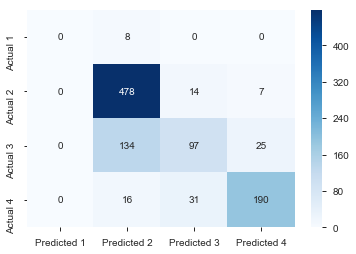

***************************************************
 Classification report
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.75      0.96      0.84       499
           3       0.68      0.38      0.49       256
           4       0.86      0.80      0.83       237

   micro avg       0.77      0.77      0.77      1000
   macro avg       0.57      0.53      0.54      1000
weighted avg       0.75      0.77      0.74      1000



C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Harsh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
print(metrics.accuracy_score(y_test,lgb_y_pred))
print('*************************************************')
print('Confusion matrix')
lgb_cfm=metrics.confusion_matrix(y_test, lgb_y_pred)


lbl1=["Predicted 1", "Predicted 2","Predicted 3",'Predicted 4']
lbl2=["Actual 1", "Actual 2","Actual 3","Actual 4"]

sns.heatmap(lgb_cfm, annot=True, cmap="Blues", fmt="d", xticklabels=lbl1, yticklabels=lbl2)

plt.show()

print('***************************************************\n Classification report')
print(metrics.classification_report(y_test,lgb_y_pred))

In [56]:
y_train.value_counts()

2    1938
3    1029
4    1021
1      12
Name: grade, dtype: int64

In [62]:
import eli5
xgboost_model = xgb_model

#### Model interpretability using Eli5 and SHAP

In [66]:
eli5.show_weights(xgboost_model,feature_names=x_train.columns.values)

So it denotes that "% Iron concentrate is more prominent feature that decides which class it belongs to."

Taking example of first sample

In [67]:
eli5.explain_prediction(xgboost_model,x_test.iloc[1])

Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n       colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',\n       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,\n       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n       nthread=None, num_class=4, objective='multi:softprob',\n       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,\n       seed=42, silent=None, subsample=1, verbosity=1)", description='\nFeatures with largest coefficients per class.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[], neg=[FeatureWeight(feature='<BIAS>', weight=-3.914140809463286, std=None, value=1.0), FeatureWeight(feature='% Iron Concentrate', weight=-0.767956796611289, std=None, value=64.94), FeatureWeight(feature='Flotation Column 06 Level', weight=-0.06955952338062504, std=None, value=406.087), FeatureWeight(feature='Flotation Column 03 Level', weight=-0.06804321966933811, std=None, value=440.978), FeatureWeight(feature='% Iron Feed', weight=-0.05285030324847692, std=None, value=55.94), FeatureWeight(feature='Flotation Column 06 Air Flow', weight=-0.04073195013184197, std=None, value=295.279), FeatureWeight(feature='Hour', weight=-0.03427513587259748, std=None, value=10.0), FeatureWeight(feature='Starch Flow', weight=-0.031028315004838068, std=None, value=2199.62), FeatureWeight(feature='% Silica Feed', weight=-0.02998289108629626, std=None, value=13.85), FeatureWeight(feature='Month_5', weight=-0.013909660906076558, std=None, value=0.0), FeatureWeight(feature='Hour_12', weight=-0.012457502534690974, std=None, value=0.0), FeatureWeight(feature='Flotation Column 04 Air Flow', weight=-0.009909998997199493, std=None, value=299.47), FeatureWeight(feature='Flotation Column 01 Air Flow', weight=-0.006969019763241942, std=None, value=299.893), FeatureWeight(feature='Ore Pulp pH', weight=-0.0005835662302024966, std=None, value=9.51868)], pos_remaining=0, neg_remaining=0), proba=0.001279481, score=-5.052398692899998, weighted_spans=None, heatmap=None), TargetExplanation(target=2, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=0.8210415884745773, std=None, value=1.0), FeatureWeight(feature='Amina Flow', weight=0.25649176563643145, std=None, value=439.407), FeatureWeight(feature='Flotation Column 01 Air Flow', weight=0.21731024926960424, std=None, value=299.893), FeatureWeight(feature='Flotation Column 02 Air Flow', weight=0.10212077053806873, std=None, value=302.885), FeatureWeight(feature='Ore Pulp pH', weight=0.05417668724152867, std=None, value=9.51868), FeatureWeight(feature='Flotation Column 04 Air Flow', weight=0.018421405564394488, std=None, value=299.47), FeatureWeight(feature='day', weight=0.009519614750186665, std=None, value=6.0), FeatureWeight(feature='Flotation Column 06 Level', weight=0.

Negative sign denotes that it has reverse impact, so for y=1 -0.768	% Iron Concentrate and for y=3 +0.387	% Iron Concentrate means particular record belongs to 3 grade. lets check

In [68]:
y_test.iloc[1]

3

In [69]:
eli5.explain_prediction(xgboost_model,x_test.iloc[30])

Explanation(estimator="XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n       colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',\n       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,\n       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n       nthread=None, num_class=4, objective='multi:softprob',\n       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,\n       seed=42, silent=None, subsample=1, verbosity=1)", description='\nFeatures with largest coefficients per class.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='% Iron Concentrate', weight=0.7360108916510469, std=None, value=66.2), FeatureWeight(feature='Starch Flow', weight=0.4447526777063456, std=None, value=4283.34), FeatureWeight(feature='% Iron Feed', weight=0.3593514374075735, std=None, value=47.05), FeatureWeight(feature='Flotation Column 06 Level', weight=0.1398258722597763, std=None, value=336.23), FeatureWeight(feature='% Silica Feed', weight=0.13518054666690024, std=None, value=28.14), FeatureWeight(feature='Flotation Column 04 Level', weight=0.03150181586614635, std=None, value=372.309), FeatureWeight(feature='Amina Flow', weight=0.030907208263080087, std=None, value=427.017)], neg=[FeatureWeight(feature='<BIAS>', weight=-3.914140809463286, std=None, value=1.0), FeatureWeight(feature='Flotation Column 07 Level', weight=-0.5500376966565866, std=None, value=349.14099999999996), FeatureWeight(feature='Ore Pulp Density', weight=-0.4772892356042447, std=None, value=1.7322), FeatureWeight(feature='Ore Pulp pH', weight=-0.11344910206921828, std=None, value=9.98347), FeatureWeight(feature='Ore Pulp Flow', weight=-0.07975075597606213, std=None, value=392.389), FeatureWeight(feature='day', weight=-0.07522856850832568, std=None, value=2.0), FeatureWeight(feature='Hour_6', weight=-0.051768615034275337, std=None, value=0.0), FeatureWeight(feature='Flotation Column 04 Air Flow', weight=-0.030793657385116552, std=None, value=300.183), FeatureWeight(feature='Month_8', weight=-0.02950527087472179, std=None, value=0.0), FeatureWeight(feature='Flotation Column 01 Air Flow', weight=-0.026159547137342306, std=None, value=299.666), FeatureWeight(feature='Flotation Column 05 Air Flow', weight=-0.014979095041134795, std=None, value=299.716), FeatureWeight(feature='Hour', weight=-0.013959320077784054, std=None, value=15.0), FeatureWeight(feature='Flotation Column 02 Air Flow', weight=-0.012964824559578859, std=None, value=298.878), FeatureWeight(feature='day_5', weight=-0.011512352939515708, std=None, value=0.0), FeatureWeight(feature='Flotation Column 03 Level', weight=-0.0016724999536764165, std=None, value=397.222)], pos_remaining=0, neg_remaining=0), proba=0.0023573025, score=-3.525680901459999, weighted_spans=None, heatmap=None), TargetExplanation(target=2

In [70]:
y_test.iloc[30]

2

In [76]:
import numpy.core.multiarray
import shap

In [ ]:
xgboost_explainer_shap=shap.TreeExplainer(xgb_model)

In [ ]:
print('Actual label\n',y_test[1])
print('******')
shap_values1=xgboost_explainer_shap.shap_values(x_test.iloc[1])
data_to_predict1 = x_test.iloc[1]
shap.initjs()
shap.force_plot(xgboost_explainer_shap.expected_value[2],shap_values1[2],data_to_predict1)

In [ ]:
print('Actual label\n',y_test[1])
print('******')
shap_values30=xgboost_explainer_shap.shap_values(x_test.iloc[30])
data_to_predict30 = x_test.iloc[30]
shap.initjs()
shap.force_plot(xgboost_explainer_shap.expected_value[1],shap_values30[1],data_to_predict30)